# NBA : Why Isn't My Team making the Playoffs?

# Gathering Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Seaborn
import seaborn as sns
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

#Plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
#Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()


### Dataset was imported from Kaggle and was already in train_test_split so I remade the original 

In [2]:
nba_train = pd.read_csv('NBA_train.csv')

In [3]:
nba_test =pd.read_csv('NBA_test.csv')

In [4]:
nba = pd.concat([nba_train,nba_test])
nba = nba.reset_index(drop=True)
nba.head()

# pd.set_option('display.max_rows', 1000) | if needed to display full df
# plt.xticks(rotation=90); | if need to rotate labels

,SeasonEnd,Team,Playoffs,W,PTS,oppPTS,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV
0,1980,Atlanta Hawks,1,50,8573,8334,3261,7027,3248,6952,13,75,2038,2645,1369,2406,1913,782,539,1495
1,1980,Boston Celtics,1,61,9303,8664,3617,7387,3455,6965,162,422,1907,2449,1227,2457,2198,809,308,1539
2,1980,Chicago Bulls,0,30,8813,9035,3362,6943,3292,6668,70,275,2019,2592,1115,2465,2152,704,392,1684
3,1980,Cleveland Cavaliers,0,37,9360,9332,3811,8041,3775,7854,36,187,1702,2205,1307,2381,2108,764,342,1370
4,1980,Denver Nuggets,0,30,8878,9240,3462,7470,3379,7215,83,255,1871,2539,1311,2524,2079,746,404,1533


### *What is the magic number to make the dance?*
- What is the avg number of wins for a playoff team?

In [5]:
#New DataFrame with only playoff teams
nba_playoffs = nba[nba['Playoffs']==1]

nba_playoffs.describe().transpose().head(3)

,count,mean,std,min,25%,50%,75%,max
SeasonEnd,494.0,1996.336032,9.472734,1980.0,1988.0,1996.0,2005.00,2013.0
Playoffs,494.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
W,494.0,49.793522,7.507797,30.0,44.0,50.0,55.75,72.0


Text(0.5, 0, 'Wins')

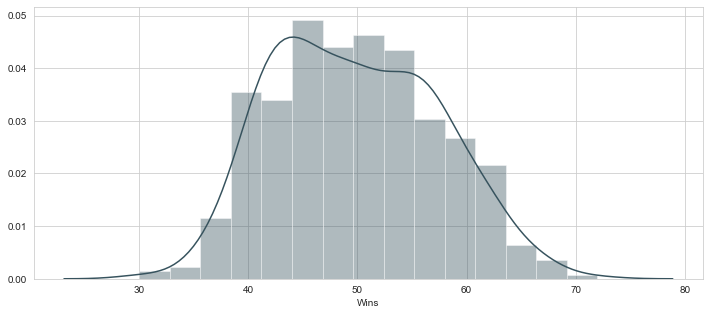

In [6]:
# Distribution of Wins by Playoff teams
plt.figure(figsize=(12,5))
sns.distplot(nba_playoffs['W'])
plt.xlabel('Wins')

Text(0, 0.5, 'Playoff Teams')

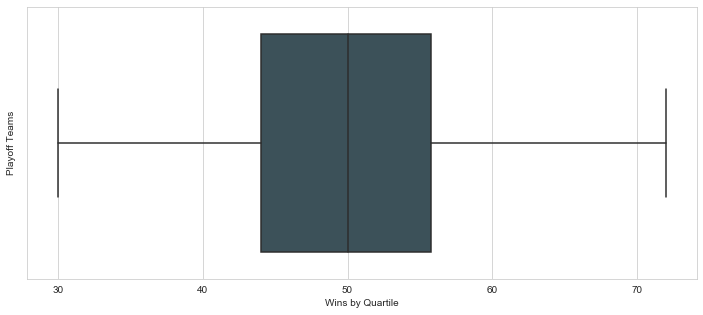

In [7]:
# Box plot of wins
plt.figure(figsize=(12,5))
sns.boxplot(nba_playoffs['W']);
plt.xlabel('Wins by Quartile')
plt.ylabel('Playoff Teams')

# Wins to Make Playoffs Based on past 32 NBA Season 
- The avg team wins ~49 games
- Most teams fall inbetween 42 & 56 wins

Teams should strive for winning 56 games or more in a season to statistically rely on making the Playoffs. Teams that started off slow can infer from this data that is 42 games is within striking distance, they still have a decent statistical chance of making the Playoffs.


# Exploratory Data Analysis: Determine How to Get Wins

## New  Features
- 2pt % (make/attempts)
- 3pt% (make/attempts)
- FT %(make/attempts)
- RB Ratio (offensive/defensive)
- Assist to PTS (assits/pts)
- TO diff ((blk + stl)- TO) 
- Pt diff (pts-opp pts)

#### From the dataset I think these metrics will have the highest correlation to winning basketball games. Most of these are intuitive, but it will be interesting to see the numerical backed arguments for which is most impactful. I'm personlly most interested to see if the assist to points metric has any weight for determining wins. 

In [8]:
#Calculating Metrics into new Columns
nba['2P%'] = nba['2P']/nba['2PA']*100
nba['3P%'] = nba['3P']/nba['3PA']*100
nba['FT%'] = nba['FT']/nba['FTA']*100
nba['AST%'] = nba['AST']/nba['PTS']*100
nba['ORB%'] = nba['ORB']/nba['DRB']*100
nba['TO_DIFF'] = (nba['BLK']+nba['STL'])-nba['TOV']
nba['PTS_DIFF'] = nba['PTS']-nba['oppPTS']


In [9]:
#Creating New Dataset to analyis metrics
nba_feat=nba[['Playoffs', 'W','2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']]
x_feat=['2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']
nba_feat.head()

,Playoffs,W,2P%,3P%,FT%,AST%,ORB%,TO_DIFF,PTS_DIFF
0,1,50,46.720368,17.333333,77.051040,22.314242,56.899418,-174,239
1,1,61,49.605169,38.388626,77.868518,23.626787,49.938950,-422,639
2,0,30,49.370126,25.454545,77.893519,24.418473,45.233266,-588,-222
3,0,37,48.064680,19.251337,77.188209,22.521368,54.892902,-264,28
4,0,30,46.832987,32.549020,73.690429,23.417436,51.941363,-383,-362


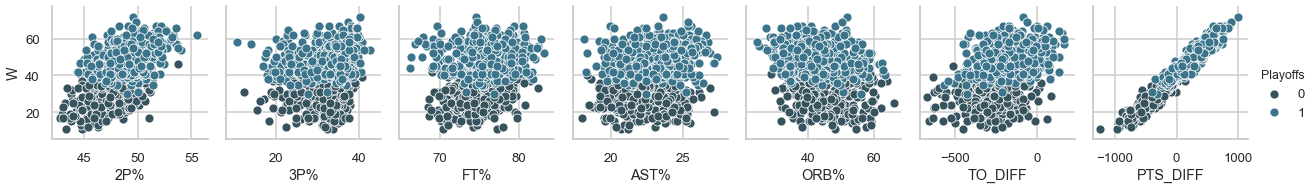

In [10]:
sns.set_context('talk',font_scale=.8)
sns.pairplot(data=nba_feat,y_vars=['W'],x_vars=x_feat,hue='Playoffs');

## Training and Testing Data

I set a variable X equal to the new numerical features and Y equal to the Wins.

In [11]:
#split by .25 so trainand test sets are full seasons (24 train, 8 test, 32 total)
nba['SeasonEnd'].nunique()


32

In [12]:
X = nba_feat[[ '2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']]
y = nba_feat['W']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

## Training the Model

In [14]:
from sklearn.linear_model import LinearRegression
#Create LM Object
lm = LinearRegression()
#Fit model to data
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 0.08434548 -0.02955636 -0.01997708  0.12829487 -0.01605381  0.00140509
  0.03210437]


In [16]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']


## Predicting Test Data

Text(0, 0.5, 'Preditcted Y')

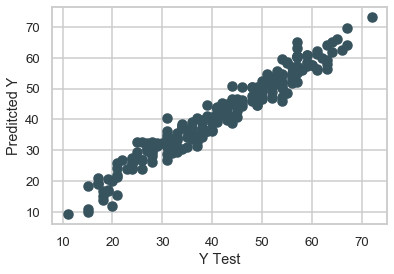

In [17]:
predict = lm.predict(X_test)

plt.scatter(y_test,predict)
plt.xlabel('Y Test')
plt.ylabel('Preditcted Y')

## Evaluating the Model

In [18]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))

MAE: 2.554918805674317
MSE: 9.72799550016141
RMSE: 3.1189734689736315


In [19]:
r = metrics.explained_variance_score(y_test,predict)
print(f'R^2 = {r}')

R^2 = 0.9465179805903512


# model explained ~ 94% of predicted wins per team with 3 win Std

## Residuals

- Error between model line and actual value

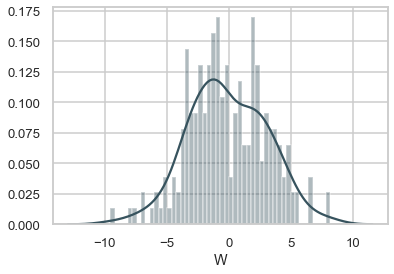

In [20]:
sns.distplot(y_test-predict,bins=50);

In [21]:
coeffecients

,Coeffecient
2P%,0.084345
3P%,-0.029556
FT%,-0.019977
AST%,0.128295
ORB%,-0.016054
TO_DIFF,0.001405
PTS_DIFF,0.032104


# Conclusions:

### Interpreting the coefficients:
#### *Remember these features have very different units*
        - Example: Increasing 1 unit of shooting % is much harder than scoring one more point.

- Holding all other features fixed, a 1 unit increase in **2P%** is associated with an **increase of ~8.4% of a win**.
- Holding all other features fixed, a 1 unit increase in **AST%** is associated with an **increase of ~12% of a win**.
- Holding all other features fixed, a 1 unit increase in **PTS_DIFF** is associated with an **increase of ~3% of a win**.

##### *ONE Win could be the difference between 2nd season and going home early!*

## What can Teams take away from this anaysis?

#### Convert 2PT Atempts efficiently
    - This is obvious, but if team brought up a shot chart they could dive deeper and see what number of far 2PT 
    shot should be eliminated. Main focus here is to establish which areas to focus on.
#### Sharing the Ball to Score
    - Typically teams want superstars, but if that Free Agent is known to have low assist, might want to head 
    another direction. Again, deeper dive into this for individual team, I would look to see the assit totals 
    for the team based on if said player was on the floor.
#### Outscoring by Wide Margin 
    - This is the most obvious, if you score more than the other team by a wide margin means you are going to 
    win games. Deeper look into this might suggest team can stay focus and speaks to pyshcology of said team. 
    Also, look into if when the largest margin occur and take a closer look
    
### Surprising Findings

#### Offensive Rebounds
    - "Traditional" thought is more offensive rebounds lead to more points, but that in this case doesn't appear 
    to show in the data
#### Turnover Differential 
    - "Traditional" thought is win the turnover battle, win the game. Data suggest otherwise. One reason could be 
    that not every BLK turns into a turnover
#### 3P%
    - "Traditional" thought is 3's are worth more than 2's so if you shot a higher % the result would be positivly
    correlated